In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

import nltk
from nltk.stem import WordNetLemmatizer
from copy import deepcopy

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report


In [2]:
# download dataset from hungging face
dataset = load_dataset("tweet_eval", "sentiment")

dataset

Found cached dataset tweet_eval (C:/Users/Splute/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
data_train = pd.DataFrame(dataset['train'])
data_val = pd.DataFrame(dataset['validation'])
data_test = pd.DataFrame(dataset['test'])

# # Balance the amount of each class
# SEED = 66

# num_train_per_class = 7000
# # num_val_per_class = 1000
# num_test_per_class = 1500

# balanced_train_data = data_train.groupby('label', group_keys=False).apply(lambda x:\
#         x.sample(min(len(x), num_train_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)
# # balanced_val_data = data_val.groupby('label', group_keys=False).apply(lambda x:\
# #         x.sample(min(len(x), num_val_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)
# balanced_test_data = data_test.groupby('label', group_keys=False).apply(lambda x:\
#         x.sample(min(len(x), num_test_per_class), random_state=SEED)).sample(frac=1, random_state=SEED)

data = data_train.append(data_val, ignore_index=True) # ignore_index makes the index to be continued

print('size of training set: %s' % (len(data_train['text'])))
print('size of validation set: %s' % (len(data_val['text'])))
print(data.label.value_counts())

data.head(10)

size of training set: 45615
size of validation set: 2000
1    21542
2    18668
0     7405
Name: label, dtype: int64


,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2
5,@user LIT MY MUM 'Kerry the louboutins I wonde...,2
6,"""\"""""""" SOUL TRAIN\"""""""" OCT 27 HALLOWEEN SPECIA...",2
7,So disappointed in wwe summerslam! I want to s...,0
8,"""This is the last Sunday w/o football .....,NF...",2
9,@user @user CENA & AJ sitting in a tree K-I-S-...,1


## Import word vectors

In [5]:
# import word vectors

words = dict()
wird_filepath = '../embeddings\glove.twitter.27B\glove.twitter.27B.100d.txt'

def add_to_dict(d, filename):
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')

            try:
                d[line[0]] = np.array(line[1:],dtype=float)
            except:
                continue

add_to_dict(words, wird_filepath)

In [6]:
len(words)

1193514

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Splute\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Use regular expressions to define word segmentation rules,
# and split text according to patterns that match regular expressions
tokenizer = nltk.RegexpTokenizer(r"\w+")

# find the root-word
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('feet')

# preprocess
def msg_to_token_list(string):
    tokens = tokenizer.tokenize(string)
    lowercased_tokens = [token.lower() for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in lowercased_tokens]
    useful_tokens = [token for token in lemmatized_tokens if token in words]

    return useful_tokens

In [9]:
msg_to_token_list('@#Did you feel happy?')

['did', 'you', 'feel', 'happy']

In [10]:
def msg_to_word_vectors(msg, word_dict = words):
    processed_list_tokens = msg_to_token_list(msg)

    vectors = []

    for token in processed_list_tokens:
        if token not in word_dict:
            continue

        token_vector = word_dict[token]
        vectors.append(token_vector)

    return np.array(vectors, dtype=float)

In [11]:
msg_to_word_vectors('@#Did you feel happy?').shape


(4, 100)

## data preprocess

In [28]:
# get x and y
def dff_to_X_y(dff):
    y = dff['label'].to_numpy().astype(int)

    all_word_vector_sequences = []

    for msg in dff['text']:
        msg_as_vector_seq = msg_to_word_vectors(msg)

        if msg_as_vector_seq.shape[0] == 0:
            msg_as_vector_seq = np.zeros(shape=(1,100))

        all_word_vector_sequences.append(msg_as_vector_seq)

    return all_word_vector_sequences, y


In [29]:
X_train, y_train = dff_to_X_y(data_train)
print(len(X_train), len(X_train[0]))

45615 16


In [30]:
print(len(X_train), len(X_train[1]))


45615 13


(array([1.5000e+01, 5.2600e+02, 3.5310e+03, 5.4680e+03, 1.1739e+04,
        1.0249e+04, 1.0155e+04, 3.2530e+03, 6.7000e+02, 9.0000e+00]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <BarContainer object of 10 artists>)

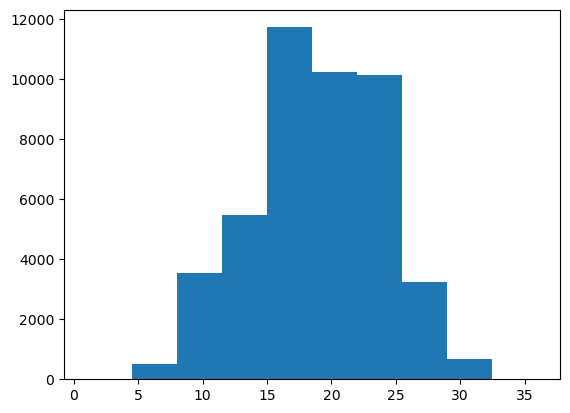

In [31]:
# do something for the sequence length
sequence_lengths = []

for i in range(len(X_train)):
    sequence_lengths.append(len(X_train[i]))

plt.hist(sequence_lengths)

In [32]:
pd.Series(sequence_lengths).describe()

count    45615.000000
mean        18.721407
std          5.015178
min          1.000000
25%         15.000000
50%         19.000000
75%         22.000000
max         36.000000
dtype: float64

In [33]:
def pad_X(X, desired_sequence_length = 38):
    X_copy = deepcopy(X) # create a totally new copy

    for i, x in enumerate(X):
        x_seq_len = x.shape[0]
        sequence_length_difference = desired_sequence_length - x_seq_len

        pad = np.zeros(shape=(sequence_length_difference, 100))

        X_copy[i] = np.concatenate([x,pad])

    return np.array(X_copy).astype(float)

In [34]:
X_train = pad_X(X_train)

X_train.shape

(45615, 38, 100)

In [35]:
y_train.shape

(45615,)

In [36]:
X_val, y_val = dff_to_X_y(data_val)
X_val = pad_X(X_val)

X_val.shape,y_val.shape

((2000, 38, 100), (2000,))

In [37]:
X_test, y_test = dff_to_X_y(data_test)
X_test = pad_X(X_test)

X_test.shape,y_test.shape

((12284, 38, 100), (12284,))

## model

In [42]:
model = Sequential()

model.add(layers.Input(shape=(38,100)))
model.add(layers.Bidirectional(layers.LSTM(128, dropout=0.2,return_sequences=True)))
model.add(layers.LSTM(64, dropout=0.2,return_sequences=True))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 38, 256)           234496    
_________________________________________________________________
lstm_3 (LSTM)                (None, 38, 64)            82176     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                155712    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 472,579
Trainable params: 472,579
Non-trainable params: 0
_________________________________________________________________


In [44]:
cp = ModelCheckpoint('../models/temp',save_best_only=True)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
frequencies = pd.value_counts(data_train['label'])
frequencies

1    20673
2    17849
0     7093
Name: label, dtype: int64

In [52]:
weights = {
    0: frequencies.sum() / frequencies[0],
    1: frequencies.sum() / frequencies[1],
    2: frequencies.sum() / frequencies[2]
}
weights

{0: 6.43098829832229, 1: 2.2065012334929617, 2: 2.5556053560423555}

In [55]:
model.fit(X_train,
          y_train,
          validation_data=(X_val, y_val),
          epochs=20,
          batch_size=64,
          callbacks=[cp],
          class_weight=weights)

Epoch 1/20
713/713 [==============================] - 15s 18ms/step - loss: 2.0654 - accuracy: 0.6639 - val_loss: 0.7795 - val_accuracy: 0.6385
Epoch 2/20
713/713 [==============================] - 13s 18ms/step - loss: 1.9988 - accuracy: 0.6761 - val_loss: 0.7965 - val_accuracy: 0.6335
Epoch 3/20
713/713 [==============================] - 13s 18ms/step - loss: 1.9638 - accuracy: 0.6782 - val_loss: 0.7819 - val_accuracy: 0.6440
Epoch 4/20
713/713 [==============================] - 13s 18ms/step - loss: 1.9408 - accuracy: 0.6863 - val_loss: 0.8095 - val_accuracy: 0.6435
Epoch 5/20
713/713 [==============================] - 13s 18ms/step - loss: 1.9199 - accuracy: 0.6888 - val_loss: 0.8394 - val_accuracy: 0.6120
Epoch 6/20
713/713 [==============================] - 13s 18ms/step - loss: 1.9018 - accuracy: 0.6928 - val_loss: 0.7744 - val_accuracy: 0.6585
Epoch 7/20
713/713 [==============================] - 13s 19ms/step - loss: 1.8839 - accuracy: 0.6938 - val_loss: 0.8084 - val_accuracy:

In [58]:
best_model = load_model('../models/GloVe_LSTM')

predictions = best_model.predict(X_test)
res = []
for pred in predictions:
  res.append(pred.argmax())

In [59]:
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64      3972
           1       0.66      0.66      0.66      5937
           2       0.58      0.64      0.61      2375

    accuracy                           0.64     12284
   macro avg       0.63      0.64      0.64     12284
weighted avg       0.65      0.64      0.64     12284

